In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
header = ['trade_id','price','quantity','order_id','timestamp','is_buyer_maker']
df = pd.read_csv('./Data/BTCUSDT-trades-2023-05-26.csv',header=0 , names = header)
df.head()
df = df[:25000]

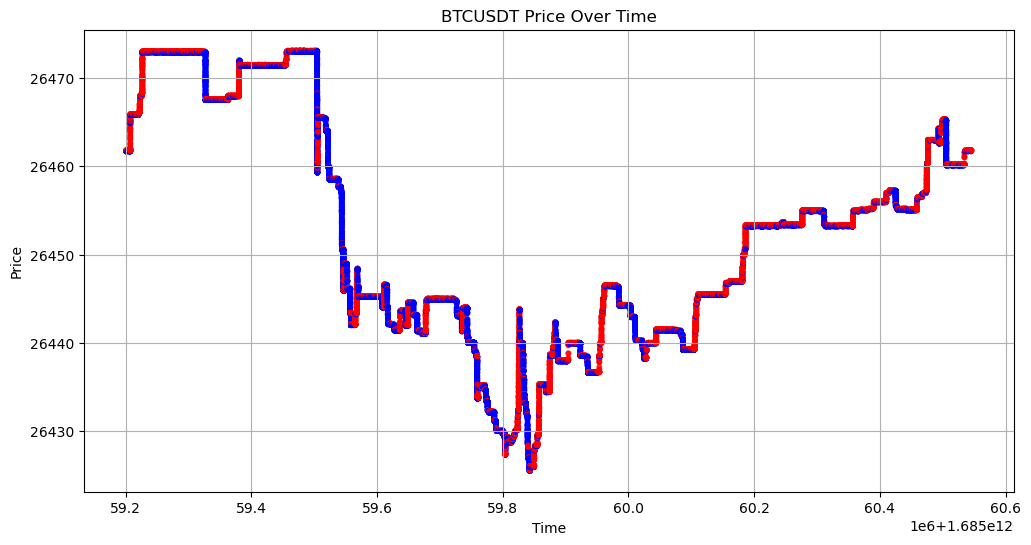

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.figure(figsize=(12, 6))
plt.scatter(
    df['timestamp'], df['price'],
    c=df['is_buyer_maker'].map({True: 'blue', False: 'red'}), alpha=0.7, s=10
)

# 설정: Y축의 과학적 표기법 완전 비활성화
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('BTCUSDT Price Over Time')
plt.grid()
plt.show()

In [5]:
def closed_time_series(df, time_interval):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.set_index('timestamp')
    df['buy_quantity'] = np.where(df['is_buyer_maker'], df['quantity'], 0)
    df['sell_quantity'] = np.where(df['is_buyer_maker'], 0, df['quantity'])
    df = df.resample(str(time_interval)+'S').agg({'price':'last', 'quantity':'sum', 'buy_quantity':'sum', 'sell_quantity':'sum'})
    df['return'] = df['price'].diff()
    df = df.dropna()
    return df

In [6]:
df_closed = closed_time_series(df,1)

In [7]:
df_closed

,price,quantity,buy_quantity,sell_quantity,return
timestamp,,,,,
2023-05-26 00:00:01,26461.7,0.544,0.349,0.195,0.0
2023-05-26 00:00:04,26461.8,0.484,0.258,0.226,0.1
2023-05-26 00:00:05,26461.7,0.005,0.005,0.000,-0.1
2023-05-26 00:00:06,26461.8,1.292,0.346,0.946,0.1
2023-05-26 00:00:07,26465.9,8.756,0.344,8.412,4.1
...,...,...,...,...,...
2023-05-26 00:22:19,26461.8,0.056,0.000,0.056,0.1
2023-05-26 00:22:20,26461.7,0.754,0.586,0.168,-0.1
2023-05-26 00:22:21,26461.7,0.036,0.002,0.034,0.0


In [8]:
df_closed['ofi'] = df_closed['buy_quantity'] - df_closed['sell_quantity']

In [9]:
df_closed['after_return'] = df_closed['return'].shift(-1)

In [10]:
df_closed

,price,quantity,buy_quantity,sell_quantity,return,ofi,after_return
timestamp,,,,,,,
2023-05-26 00:00:01,26461.7,0.544,0.349,0.195,0.0,0.154,0.1
2023-05-26 00:00:04,26461.8,0.484,0.258,0.226,0.1,0.032,-0.1
2023-05-26 00:00:05,26461.7,0.005,0.005,0.000,-0.1,0.005,0.1
2023-05-26 00:00:06,26461.8,1.292,0.346,0.946,0.1,-0.600,4.1
2023-05-26 00:00:07,26465.9,8.756,0.344,8.412,4.1,-8.068,0.0
...,...,...,...,...,...,...,...
2023-05-26 00:22:19,26461.8,0.056,0.000,0.056,0.1,-0.056,-0.1
2023-05-26 00:22:20,26461.7,0.754,0.586,0.168,-0.1,0.418,0.0
2023-05-26 00:22:21,26461.7,0.036,0.002,0.034,0.0,-0.032,0.1


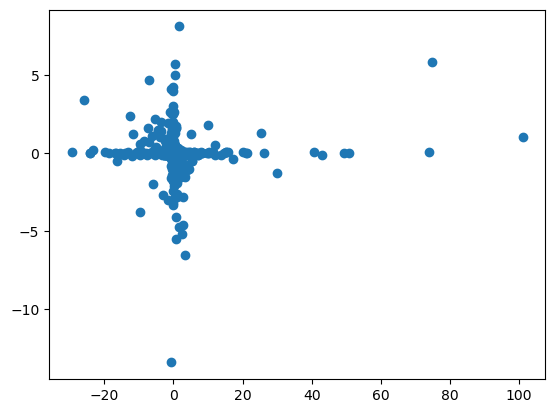

In [11]:
plt.scatter(df_closed['ofi'][:len(df_closed) - 2],df_closed['after_return'][:len(df_closed) - 2])

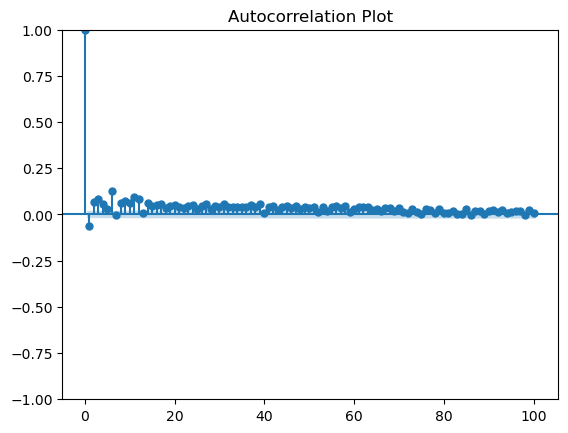

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

price_diff = df['price'].diff()
# 자기상관 함수 시각화
plot_acf(price_diff[1:10000], lags=100)
plt.title('Autocorrelation Plot')
plt.show()


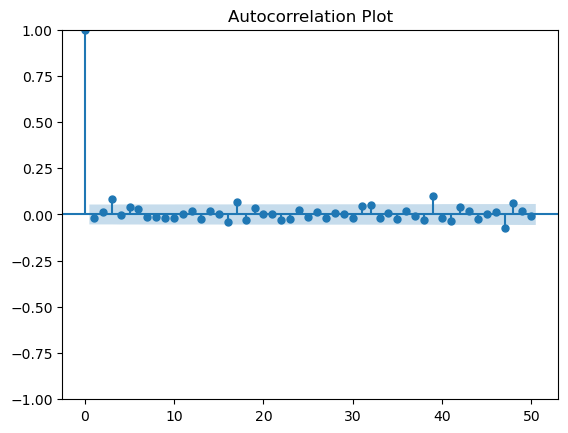

In [13]:
price_diff = df_closed['return']
# 자기상관 함수 시각화
plot_acf(price_diff[1:10000], lags=50)
plt.title('Autocorrelation Plot')
plt.show()

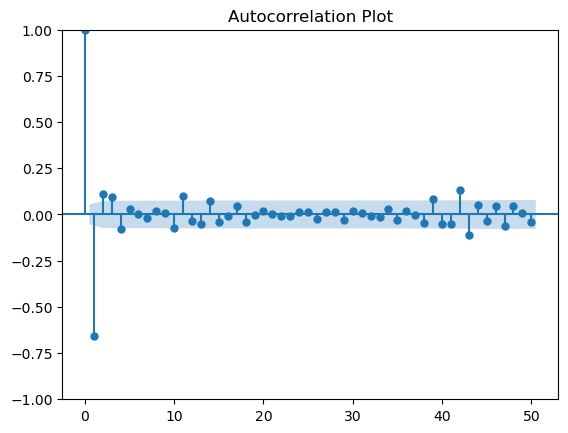

In [14]:
df_closed['ofi_1'] = df_closed['ofi'].diff()
df_closed['ofi_2'] = df_closed['ofi_1'].diff()
# 자기상관 함수 시각화
plot_acf(df_closed['ofi_2'][2:], lags=50)
plt.title('Autocorrelation Plot')
plt.show()

In [15]:
df_closed

,price,quantity,buy_quantity,sell_quantity,return,ofi,after_return,ofi_1,ofi_2
timestamp,,,,,,,,,
2023-05-26 00:00:01,26461.7,0.544,0.349,0.195,0.0,0.154,0.1,NaN,NaN
2023-05-26 00:00:04,26461.8,0.484,0.258,0.226,0.1,0.032,-0.1,-0.122,NaN
2023-05-26 00:00:05,26461.7,0.005,0.005,0.000,-0.1,0.005,0.1,-0.027,0.095
2023-05-26 00:00:06,26461.8,1.292,0.346,0.946,0.1,-0.600,4.1,-0.605,-0.578
2023-05-26 00:00:07,26465.9,8.756,0.344,8.412,4.1,-8.068,0.0,-7.468,-6.863
...,...,...,...,...,...,...,...,...,...
2023-05-26 00:22:19,26461.8,0.056,0.000,0.056,0.1,-0.056,-0.1,0.015,-0.206
2023-05-26 00:22:20,26461.7,0.754,0.586,0.168,-0.1,0.418,0.0,0.474,0.459
2023-05-26 00:22:21,26461.7,0.036,0.002,0.034,0.0,-0.032,0.1,-0.450,-0.924


In [16]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
# timestamp -> ds, price -> y로 이름 변경
prophet_df = df_closed.rename(columns={'timestamp': 'ds', 'price': 'y'})

# 추가 feature 포함
prophet_df = prophet_df[['ds', 'y', 'quantity', 'buy_quantity', 'sell_quantity', 'ofi', 'ofi_1', 'ofi_2']]

# NaN 값 처리 (Prophet은 NaN을 허용하지 않음)
prophet_df = prophet_df.fillna(0)

# 2. Prophet 모델 생성
model = Prophet()
model.add_regressor('quantity')
model.add_regressor('buy_quantity')
model.add_regressor('sell_quantity')
model.add_regressor('ofi')
model.add_regressor('ofi_1')
model.add_regressor('ofi_2')

# 3. 모델 학습
model.fit(prophet_df)

# 4. 미래 데이터 생성
future = model.make_future_dataframe(periods=30, freq='T')  # 30분 예측

# 추가 feature 추가: 미래 feature 값을 0으로 채우거나, 최근 데이터로 대체
future = future.merge(
    prophet_df[['ds', 'quantity', 'buy_quantity', 'sell_quantity', 'ofi', 'ofi_1', 'ofi_2']],
    on='ds',
    how='left'
).fillna(0)  # 미래 데이터에 NaN을 0으로 처리

# 5. 예측
forecast = model.predict(future)

# 6. 결과 확인
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# 7. 시각화
model.plot(forecast)
plt.show()

model.plot_components(forecast)
plt.show()


KeyError: "['ds'] not in index"